In [1]:
import pandas as pd
import requests
import requests_cache
import re
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy.stats as stats
import json

%matplotlib inline
requests_cache.install_cache("cache5")

In [115]:
raw_recipes = pd.read_json('full_format_recipes.json', convert_dates=False)
raw_recipes.dropna(how='all', inplace=True) # remove recipes with NaNs for all columns


In [116]:
raw_recipes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20111 entries, 0 to 20129
Data columns (total 11 columns):
calories       15976 non-null float64
categories     20111 non-null object
date           20111 non-null object
desc           13495 non-null object
directions     20111 non-null object
fat            15908 non-null float64
ingredients    20111 non-null object
protein        15929 non-null float64
rating         20100 non-null float64
sodium         15974 non-null float64
title          20111 non-null object
dtypes: float64(5), object(6)
memory usage: 1.8+ MB


In [70]:
# clean_recs = recipes.sort_values('rating', ascending=False)
# clean_recs.drop_duplicates('title', inplace=True)
# clean_recs.sort_index(inplace=True)
# clean_recs.title = clean_recs.title.str.strip()
# clean_recs.dropna(subset=['calories', 'fat', 'protein', 'sodium'], inplace=True)
# clean_recs.to_json('clean_recs.json')

In [4]:
old_recs = pd.read_json('old_recs_final.json') #original recipes with newly scraped carb. data
old_recs.reset_index(drop=True, inplace=True) #correct indexing
new_recs = pd.read_json('new_recs_final.json') #newly scraped additional recipes
new_recs.drop('link', axis=1, inplace=True) #drop link column


In [5]:
new_recs.info() # 13,000 more newly scraped recipes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13474 entries, 0 to 9999
Data columns (total 12 columns):
calories       11801 non-null float64
carb           11787 non-null float64
categories     13474 non-null object
date           13474 non-null datetime64[ns]
desc           10918 non-null object
directions     13474 non-null object
fat            11788 non-null float64
ingredients    13474 non-null object
protein        11790 non-null float64
rating         13452 non-null float64
sodium         11801 non-null float64
title          13474 non-null object
dtypes: datetime64[ns](1), float64(6), object(5)
memory usage: 1.3+ MB


In [17]:
# Joining the original and new recipes dataframes
recipes = old_recs.append(new_recs, ignore_index=True)
recipes.info() # Almost 3,000 recipes missing carb when other nutri. data are present

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27518 entries, 0 to 27517
Data columns (total 12 columns):
calories       25845 non-null float64
carb           23186 non-null float64
categories     27518 non-null object
date           27518 non-null datetime64[ns]
desc           20273 non-null object
directions     27518 non-null object
fat            25832 non-null float64
ingredients    27518 non-null object
protein        25834 non-null float64
rating         27491 non-null float64
sodium         25845 non-null float64
title          27518 non-null object
dtypes: datetime64[ns](1), float64(6), object(5)
memory usage: 2.5+ MB


In [29]:
recipes.dropna(subset=['calories', 'fat', 'protein', 'sodium', 'carb'], how='all').drop_duplicates('title').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21031 entries, 0 to 27513
Data columns (total 12 columns):
calories       21031 non-null float64
carb           18376 non-null float64
categories     21031 non-null object
date           21031 non-null datetime64[ns]
desc           15375 non-null object
directions     21031 non-null object
fat            21019 non-null float64
ingredients    21031 non-null object
protein        21021 non-null float64
rating         21017 non-null float64
sodium         21031 non-null float64
title          21031 non-null object
dtypes: datetime64[ns](1), float64(6), object(5)
memory usage: 2.1+ MB


In [13]:
# Dropping recipes with any of the nutritional data points missing, droping duplicates
recipes = recipes.dropna(subset=['calories', 'fat', 'protein', 'sodium', 'carb']).drop_duplicates('title')
recipes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18902 entries, 0 to 27513
Data columns (total 12 columns):
calories       18902 non-null float64
carb           18902 non-null float64
categories     18902 non-null object
date           18902 non-null datetime64[ns]
desc           14120 non-null object
directions     18902 non-null object
fat            18902 non-null float64
ingredients    18902 non-null object
protein        18902 non-null float64
rating         18887 non-null float64
sodium         18902 non-null float64
title          18902 non-null object
dtypes: datetime64[ns](1), float64(6), object(5)
memory usage: 1.9+ MB


In [139]:
recipes.head(20)

,calories,carb,categories,date,desc,directions,fat,ingredients,protein,rating,sodium,title
0,426,77,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",2006-09-01 04:00:00,None,"[1. Place the stock, lentils, celery, carrot, ...",7,"[4 cups low-sodium vegetable or chicken stock,...",30,2.500,559,"Lentil, Apple, and Turkey Wrap"
1,403,34,"[Food Processor, Onion, Pork, Bake, Bastille D...",2004-08-20 04:00:00,This uses the same ingredients found in boudin...,[Combine first 9 ingredients in heavy medium s...,23,"[1 1/2 cups whipping cream, 2 medium onions, c...",18,4.375,1439,Boudin Blanc Terrine with Red Onion Confit
2,591,70,"[Citrus, Pasta, Shellfish, Sauté, Quick & Easy...",2004-08-20 12:48:48,Active time: 20 min Start to finish: 20 min,[Cook pasta in a 6- to 8-quart pot of boiling ...,19,[3/4 lb dried angel-hair pasta (capelli d'ange...,32,3.125,675,Tarragon Lime Bay Scallops Over Angel-Hair Pasta
3,682,9,"[Salad, Beef, Vegetable, No-Cook, Quick & Easy...",2004-08-20 04:00:00,Can be prepared in 45 minutes or less.,"[In a large bowl toss together the steak, the ...",50,"[1 pound leftover cooked boneless steak, slice...",47,4.375,150,Steak Salad with Pickled Vegetables
4,305,23,"[Soup/Stew, Potato, Tomato, Lobster, Fennel, G...",2004-08-20 04:00:00,Active time: 2 hr Start to finish: 3 1/2 hr (i...,"[Bring water to a boil in pot, then plunge 2 l...",16,"[4 qt water, 4 (1 1/4- to 1 1/2-lb) live lobst...",11,5.000,2849,"Lobster ""Potpies"""
5,324,40,"[Fish, Appetizer, Marinate, No-Cook, Cocktail ...",2009-07-02 04:00:00,"Marinating the fish in lemon and lime juices ""...",[Place fish in medium glass dish or bowl; spri...,15,[1 1/4 pounds very fresh (sushi-grade) fish fi...,32,5.000,1036,Mexican Ceviche Tacos
6,122,16,"[Cookies, Bake, Wheat/Gluten-Free, Grapefruit,...",2014-11-24 04:00:00,These pretty (gluten-free!) butter cookies com...,[Arrange the racks in the upper and lower rung...,6,"[1/2 teaspoon psyllium-husk powder, 1 1/2 teas...",1,5.000,18,Gluten-Free Citrus Sugar Cookies
7,726,32,"[Soup/Stew, Milk/Cream, Fish, Pork, Potato, Sh...",2004-08-20 04:00:00,A make-ahead smoked salmon butter and some fre...,[Stir salt pork pieces in heavy large pot over...,41,"[8 ounces salt pork, trimmed, cut into 1/4-inc...",56,4.375,1926,Triple Seafood Chowder with Dill
8,296,25,"[Onion, Pepper, Tomato, Low Cal, Shrimp, Gourmet]",2004-08-20 04:00:00,None,[In a deep 12-inch heavy skillet stir together...,10,"[3 tablespoons olive oil, 2 1/2 tablespoons al...",29,3.750,2141,Shrimp and Peppers in Spicy Tomato Sauce
9,613,96,"[Citrus, Onion, Pasta, Pork, Vegetable, Sauté,...",2004-08-20 12:48:48,Can be prepared in 45 minutes or less.,[Trim and discard any yellow or coarse leaves ...,15,"[1 bunch (about 1 pound) broccoli rabe, 2 slic...",26,3.750,281,Linguine with Broccoli Rabe and Lemon


In [140]:
recipes.tail(20)

,calories,carb,categories,date,desc,directions,fat,ingredients,protein,rating,sodium,title
18880,239,21,"[Tomato, Broil, Cocktail Party, Quick & Easy, ...",2004-08-20 04:00:00,None,[Combine all ingredients in bowl. Season with ...,13,"[3 large plum tomatoes (about 8 ounces), seede...",10,4.375,361,Smoked Salmon Bruschetta with Tomato-Avocado S...
18881,628,50,"[Food Processor, Fruit, Dessert, Bake, Blackbe...",2004-08-20 04:00:00,None,[Preheat oven to 375°F. Butter and flour 13x9x...,21,"[1 3/4 cups plus 1/3 cup all purpose flour, 2 ...",5,3.750,151,Mixed-Berry Crisp
18882,172,8,"[Milk/Cream, Citrus, Fish, Garlic, Olive, Pota...",2006-05-16 20:12:28,Editor's note: The recipe below is excerpted f...,"[Starting a day ahead, soak the dried cod in c...",12,"[1 pound dried, boneless salt cod, 2 cups milk...",13,3.750,1328,Portuguese-Style Salt Cod Fritters with Lemon ...
18883,392,21,"[Chicken, Appetizer, Hot Pepper, Summer, Grill...",2004-08-20 04:00:00,None,[Combine all ingredients except chicken in hea...,19,"[1 1/4 cups apple cider vinegar, 3/4 cup ketch...",25,4.375,288,Grilled Chicken Drummettes with Ancho-Cherry B...
18884,950,26,"[Chicken, Herb, Onion, Poultry, Vegetable, Bra...",2006-12-15 17:34:25,Chicken thighs are a natural for braising beca...,[Put flour in a shallow bowl. Pat chicken dry ...,64,"[1/4 cup all-purpose flour, 4 large chicken th...",63,3.750,1142,Braised Chicken with Artichokes and Peas
18885,202,0,"[Condiment/Spread, No-Cook, Quick & Easy, Mayo...",2004-08-20 04:00:00,Can be prepared in 45 minutes or less but requ...,"[In a bowl stir together the mayonnaise, the c...",22,"[1 cup bottled mayonnaise, 2 teaspoons curry p...",0,5.000,167,Curry Mayonnaise
18886,392,34,"[Soup/Stew, Vegetable, Sauté, Vegetarian, Corn...",2005-01-13 18:33:22,Calabazas are commonly found at Latino markets...,[Heat oil in a 4- to 5-quart heavy pot over mo...,26,"[2 tablespoons olive oil, 1 medium onion, coar...",6,5.000,680,"Calabaza, Corn, and Coconut Soup"
18887,285,13,"[Quick & Easy, Low Cal, Father's Day, Dinner, ...",2009-05-06 04:00:00,"Because it's such a tender cut, pork tenderloi...",[Preheat oven to 450°F. Place rack in 13x9x2- ...,11,"[1/3 cup hoisin sauce*, 1 tablespoon soy sauce...",33,3.750,484,Hoisin Pork Tenderloin with Asian Carrot Salad
18888,183,27,"[Dairy, Dessert, Vinegar, Strawberry, Spring, ...",2004-08-20 04:00:00,"Yes—vinegar and berries: The mellow balsamic, ...","[Combine vinegar, 2 teaspoons sugar, and lemon...",10,"[1/3 cup balsamic vinegar, 2 teaspoons plus 4 ...",2,4.375,78,Balsamic Strawberries with Whipped Mascarpone ...
18889,2230,122,"[Chicken, Citrus, Duck, Fruit, Poultry, Roast,...",2005-05-05 15:42:26,Anatra Ripiena,[Combine sugar and 2 2/3 cups water in heavy m...,166,"[3 cups sugar, 2 2/3 cups water, 2 oranges, en...",56,4.375,294,"Duck Stuffed with Chicken Liver, Candied Orang..."


In [3]:
# recipes.to_json('recipes_final.json')
# recipes = pd.read_json('recipes_final.json').reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18900 entries, 0 to 18899
Data columns (total 12 columns):
calories       18900 non-null int64
carb           18900 non-null int64
categories     18900 non-null object
date           18900 non-null datetime64[ns]
desc           14118 non-null object
directions     18900 non-null object
fat            18900 non-null int64
ingredients    18900 non-null object
protein        18900 non-null int64
rating         18885 non-null float64
sodium         18900 non-null int64
title          18900 non-null object
dtypes: datetime64[ns](1), float64(1), int64(5), object(5)
memory usage: 1.7+ MB


In [34]:
# Obvious errors are present with max values for all nutri. data
recipes[['calories', 'fat', 'sodium', 'protein', 'carb']].describe()
# Means are much larger than median

,calories,fat,sodium,protein,carb
count,1.890200e+04,1.890200e+04,1.890200e+04,18902.000000,18902.000000
mean,3.192302e+03,1.820167e+02,3.134880e+03,52.759920,38.300921
std,2.418679e+05,1.381977e+04,2.220264e+05,2382.787366,66.980247
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,2.110000e+02,9.000000e+00,1.222500e+02,4.000000,12.000000
50%,3.530000e+02,1.900000e+01,3.500000e+02,10.000000,26.000000
75%,6.000000e+02,3.400000e+01,7.560000e+02,29.000000,48.000000
max,3.011122e+07,1.722763e+06,2.767511e+07,236489.000000,2704.000000


In [31]:
recipes.drop(recipes.loc[recipes.calories == 0].index, inplace=True) #drop 0 calories recs

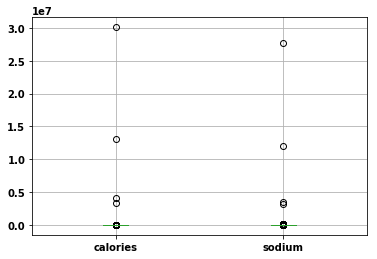

In [57]:
recipes.boxplot(['calories', 'sodium']) # Quick look at calories and sodium reveals errors

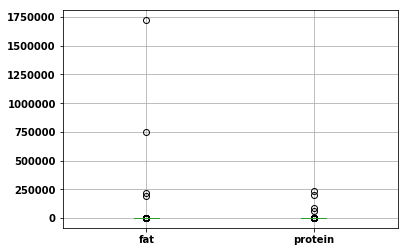

In [59]:
recipes.boxplot(['fat', 'protein'])

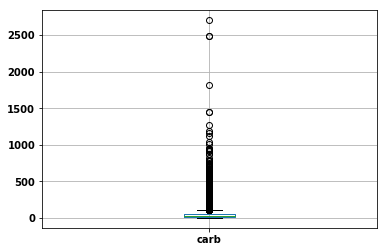

In [60]:
recipes.boxplot('carb')
# lots of outliers, carb are entirely newly scraped

In [143]:
recipes.loc[recipes.calories > 10000].sort_values('calories')
# upper_fence(recipes.calories, 3)
# 'Stuffing/Dressing' in recipes.loc[12197, 'categories']

# categories = []


,calories,carb,categories,date,desc,directions,fat,ingredients,protein,rating,sodium,title
7258,11334,2493,"[Cake, Fruit, Dessert, Bake, Vegetarian, Weddi...",2010-06-30 04:00:00.000,I spent some time in Knoxville and got to know...,[1. Preheat the oven to 350°F and place the ra...,158,"[21 ounces (4 1/4 cups) all-purpose flour, 1 t...",86,5.000,4602,Tennessee Mountain Stack Cake
189,12010,26,"[Milk/Cream, Beef, Fish, Onion, Bake, Vinegar,...",2004-08-20 04:00:00.000,None,"[In a heavy saucepan boil vinegar, water, onio...",1115,"[3/4 cup balsamic vinegar, 1 1/2 cups water, 2...",403,4.375,18212,Bacon-Wrapped Trout Stuffed with Balsamic Onio...
724,12213,8,"[Chicken, Bake, Low Fat, Kid-Friendly, Yogurt,...",2015-06-17 04:00:00.000,Yogurt gets used in two ways in this simple di...,"[Mix garlic, oil, curry powder, 1 cup yogurt, ...",919,"[1 head of garlic (about 12 cloves), peeled, f...",907,4.375,5252,Garlic-Curry Chicken Thighs With Yogurt Sauce
13150,12824,5,"[Chicken, Poultry, Bake, Super Bowl, Kid-Frien...",2004-08-20 04:00:00.000,(Spicy Baked Chicken Wings),[In a food processor or blender purée the onio...,887,"[1 onion, chopped, 2/3 cup finely chopped scal...",1164,4.375,6890,"Jamaican ""Jerk"" Chicken Wings"
10022,12900,2704,"[Vegetarian, Kid-Friendly, Vegan, Party, Small...",2012-02-13 04:00:00.000,Editor's note: Use Jim Lahey's no-knead dough ...,"[1 In a medium bowl, thoroughly blend the flou...",35,[500 grams (17 1/2 ounces or about 3 3/4 cups)...,366,3.750,1625,Pizza Dough
11555,13289,83,"[Chicken, Side, Fry, Gourmet, Dairy Free, Pean...",2004-08-20 04:00:00.000,None,[In a 6-quart kettle heat oil over moderate he...,1419,"[3 quarts vegetable oil for deep-frying, 2 1/2...",104,3.750,3232,Spicy-Sweet Glazed Chicken Wings
10615,14647,1451,"[Cake, Birthday, Buttermilk, Cream Cheese, Bak...",2016-06-30 16:00:46.702,This version of our delicious vanilla-buttermi...,[Place a rack in middle of oven; preheat to 35...,926,"[Nonstick vegetable oil spray, 4 cups cake flo...",176,4.375,7832,Double-Layer Vanilla-Buttermilk Cake with Rasp...
6253,15408,63,"[Sandwich, turkey, No-Cook, Quick & Easy, Mayo...",2005-07-15 18:12:41.000,Instead of calling for slices of roast veal—wh...,"[1. Combine the mayonnaise with the tuna, pars...",630,"[1 cup mayonnaise, 1 (6-ounce) can tuna packed...",2244,0.000,24379,Turkey (Tonnato) Sandwiches
4999,16050,50,"[Beef, Citrus, Fruit, Ginger, Braise, Super Bo...",2004-08-20 04:00:00.000,Hoisin sauce is sold at Asian markets and in t...,[Preheat oven to 300°F. Using vegetable peeler...,1480,"[4 large oranges, 3/4 cup hoisin sauce, 1/3 cu...",592,4.375,2629,Braised Orange-Ginger Short Ribs with Dried Ap...
16800,16761,47,"[Duck, Onion, Poultry, Braise, Roast, Christma...",2004-08-20 04:00:00.000,We used chef Fergus Henderson's technique for ...,[Put oven racks in upper and lower thirds of o...,1610,[12 fresh duck legs (7 to 11 lb depending on a...,477,4.375,3097,Braised Duck Legs with Shallots and Parsnips


In [105]:
def upper_fence(data, multiplier=1.5):
    per_25, per_75 = np.percentile(data, [25, 75])
    iqr = per_75 - per_25
    uf = per_75 + multiplier * iqr
    return uf, sum(list(data > uf))

In [142]:
uf_cal = upper_fence(recipes.calories, 3)[0]
recipes[recipes.calories > uf_cal].sort_values('calories')

1767.0

In [113]:
upper_fence(recipes.calories, 1.5)
recipes[recipes.fat > upper_fence(recipes.fat, 1.5)[0]].sort_values('fat')

,calories,carb,categories,date,desc,directions,fat,ingredients,protein,rating,sodium,title
7572,978,16,"[Salad, Chicken, Pork, Tomato, Side, Kid-Frien...",2015-05-27 04:00:00.000,This standard diner salad may have petered out...,"[Combine buttermilk, chimichurri sauce, mayonn...",72,"[6 tablespoons buttermilk, 6 tablespoons Chimi...",66,5.000,1363,"Summer Chef's Salad with Grilled Pork, Chicken..."
14530,1051,66,"[Duck, Garlic, Onion, Pasta, Tomato, Vegetable...",2007-01-02 19:22:55.000,Cracklings made from the leftover duck skin to...,[Heat oil in large deep skillet over medium he...,72,"[3 tablespoons extra-virgin olive oil, 1 small...",30,2.500,723,Rigatoni with Duck Ragù
17572,1101,15,"[Beer, Chicken, Garlic, Ginger, Roast, Kid-Fri...",2004-08-20 04:00:00.000,A sensational version of roast chicken that is...,[Combine all ingredients in heavy large reseal...,72,"[1 3 1/2- to 4-pound chicken, 1 12-ounce can b...",88,4.375,2078,Beer-Basted Chicken with Asian Flavors
8104,1169,31,"[Mussel, Sausage, Garlic, Seafood, Shellfish, ...",2017-03-09 19:23:25.054,"Yes, you can use any pilsner in this recipe—bu...",[Heat oil in Dutch oven over medium. Cook chor...,72,"[1 tablespoon olive oil, 8 ounces fresh Mexica...",83,3.750,2712,Beer-Steamed Mussels with Chorizo
16693,1148,94,"[Cake, Milk/Cream, Food Processor, Mixer, Berr...",2004-08-20 04:00:00.000,None,[Spray 9-inch springform pan with 3-inch-high ...,72,"[Nonstick vegetable oil spray, 1 13-ounce pack...",14,3.125,131,Raspberry and Peach Parfait Cake
8350,795,22,"[Pork, Tomato, Vegetable, Braise, Sauté, Cockt...",2009-05-05 04:00:00.000,Tinga de Puerco,[1. To make the tostaditas: Using a 2-inch rou...,72,"[8 corn tortillas, Canola oil for frying, 1 po...",19,4.375,788,Shredded Pork with Roasted Tomatoes and Chipot...
8372,1074,31,"[Chicken, Kid-Friendly, Spring, Summer, Grill/...",2015-06-03 04:00:00.000,To avoid tearing the skin on the breast or thi...,"[Prepare grill for medium-high, indirect heat ...",72,"[1/4 cup hot smoked Spanish paprika, 1/4 cup k...",83,3.750,3268,Spicy Grilled Chicken with Lemon and Parsley
972,1240,4,"[Chicken, Rice, Sauté, Quick & Easy, Shrimp, W...",2005-07-19 19:22:16.000,Pair this surf-and-turf dish with white rice t...,[Put oven rack in middle position and preheat ...,72,[4 small skinless boneless chicken breast halv...,131,3.750,1491,Chicken Breasts with Rock-Shrimp Sauce
16527,671,3,"[Sauce, Dairy, Christmas, Thanksgiving, Vegeta...",2004-08-20 04:00:00.000,"This sauce is traditionally served with fish, ...",[Cut butter into small pieces and chill. In a ...,72,"[1 stick (1/2 cup) unsalted butter, 2 tablespo...",1,3.750,22,White Butter Sauce with Cream Beurre Nantais
15460,966,65,"[Cheese, Egg, Garlic, Herb, Onion, Breakfast, ...",2006-10-11 14:26:24.000,"Hearty and full of flavor, these open-face egg...",[Preheat oven to 425°F. Combine 1 cup olive oi...,72,"[1 cup plus 2 tablespoons olive oil, 2 garlic ...",22,4.375,1044,Poached Egg Crostone with Wilted Spinach and B...


In [67]:
stats.iqr(recipes.calories) * 1.5 + np.percentile(recipes.calories,75)
# stats.iqr(recipes.calories)

1183.5

In [70]:
# recipes[recipes['title'] == 'Salted Water for Boiling ']
recipes.loc[285] == recipes.loc[10790] 
# type(recipes.loc[285, 'fat']) == type(recipes.loc[10790, 'fat'])
test = recipes.loc[recipes.duplicated(subset='title', keep=False)]
test.rating.describe()

count    4249.000000
mean        3.673070
std         1.459046
min         0.000000
25%         3.750000
50%         4.375000
75%         4.375000
max         5.000000
Name: rating, dtype: float64

In [250]:
recipes[['calories', 'fat', 'sodium', 'protein']].describe()

,calories,fat,sodium,protein
count,1.597600e+04,1.590800e+04,1.597400e+04,15929.000000
mean,6.307857e+03,3.460975e+02,6.211474e+03,99.946199
std,3.585851e+05,2.043102e+04,3.328903e+05,3835.616663
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,1.980000e+02,7.000000e+00,8.000000e+01,3.000000
50%,3.310000e+02,1.700000e+01,2.940000e+02,8.000000
75%,5.860000e+02,3.300000e+01,7.110000e+02,27.000000
max,3.011122e+07,1.722763e+06,2.767511e+07,236489.000000
